In [ ]:
!pip install pillow
!pip install split-folders

import splitfolders
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import SGD

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Apr 24 14:02:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget http://drive.genos-drive.workers.dev/allimages.zip
!mkdir cars
!unzip allimages.zip -d /content/cars

splitfolders.ratio('cars', output="output", ratio=(.8, 0.1,0.1)) 

Streaming output truncated to the last 5000 lines.
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11325.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11356.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11347.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11313.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11320.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11339.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11298.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11329.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11342.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11351.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11340.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11354.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11299.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11345.jpg  
  inflating: /content/cars/Hyundai Sona

Copying files: 16185 files [00:03, 4538.23 files/s]


In [11]:
#Parameters
batch_size = 16
size=(224, 224)
num_classes = 196
input_tensor = Input(shape=(224, 224, 3))
dropout_rate=0.2
epochs=20
opt = SGD(lr=1e-2, momentum=0.9, decay=1e-2/epochs)


In [15]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255.),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    ]
)

def load_dataset(dir):
  return keras.preprocessing.image_dataset_from_directory(
        dir,  
        image_size=size, 
        batch_size=batch_size,
        labels="inferred",
        seed=1337,
        label_mode="categorical",
        color_mode="rgb",
        shuffle=True) 
  
def data_aug(generator,data_augmentation,train):
  generator=generator.map(lambda x, y: (data_augmentation(x, training=train), y))
  return generator.prefetch(buffer_size=batch_size)



In [16]:
train_generator = load_dataset('/content/output/train')
validation_generator = load_dataset('/content/output/val')
test_generator = load_dataset('/content/output/test')


train_generator = data_aug(train_generator,data_augmentation,True)
validation_generator = data_aug(validation_generator,data_augmentation,False)
test_generator = data_aug(test_generator,data_augmentation,False)


Found 12873 files belonging to 196 classes.
Found 1524 files belonging to 196 classes.
Found 1788 files belonging to 196 classes.


In [17]:
base_model = tf.keras.applications.EfficientNetB7(input_tensor=input_tensor,include_top=False)
x = base_model.output
x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
if dropout_rate > 0:
    x = keras.layers.Dropout(dropout_rate, name='top_dropout')(x)
predictions = keras.layers.Dense(num_classes, activation='softmax', name='probs')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [18]:
his=model.fit(train_generator,
    validation_data=validation_generator,
    epochs=20)

Epoch 1/20
805/805 [==============================] - 360s 412ms/step - loss: 4.3724 - categorical_accuracy: 0.1310 - val_loss: 5.4055 - val_categorical_accuracy: 0.0052
Epoch 2/20
805/805 [==============================] - 323s 401ms/step - loss: 0.9763 - categorical_accuracy: 0.7436 - val_loss: 2.3662 - val_categorical_accuracy: 0.4409
Epoch 3/20
805/805 [==============================] - 326s 404ms/step - loss: 0.3071 - categorical_accuracy: 0.9216 - val_loss: 5.5192 - val_categorical_accuracy: 0.0059
Epoch 4/20
805/805 [==============================] - 327s 406ms/step - loss: 0.1544 - categorical_accuracy: 0.9650 - val_loss: 2.8039 - val_categorical_accuracy: 0.3596
Epoch 5/20
805/805 [==============================] - 327s 406ms/step - loss: 0.0934 - categorical_accuracy: 0.9808 - val_loss: 1.2811 - val_categorical_accuracy: 0.6660
Epoch 6/20
805/805 [==============================] - 327s 405ms/step - loss: 0.0706 - categorical_accuracy: 0.9858 - val_loss: 0.7253 - val_categoric

In [19]:
print("Evaluate on test data")
results = model.evaluate(test_generator)
print("test loss, test acc:", results)


Evaluate on test data
112/112 [==============================] - 9s 80ms/step - loss: 0.3779 - categorical_accuracy: 0.8977
test loss, test acc: [0.37786975502967834, 0.8976510167121887]


In [20]:
model.save("my_model")

INFO:tensorflow:Assets written to: my_model/assets


In [21]:
!zip -r my_model.zip my_model/

  adding: my_model/ (stored 0%)
  adding: my_model/variables/ (stored 0%)
  adding: my_model/variables/variables.index (deflated 82%)
  adding: my_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: my_model/saved_model.pb (deflated 93%)
  adding: my_model/assets/ (stored 0%)


In [22]:
!cp my_model.zip "/content/drive/MyDrive/my_model_EfficientNetB7.zip"

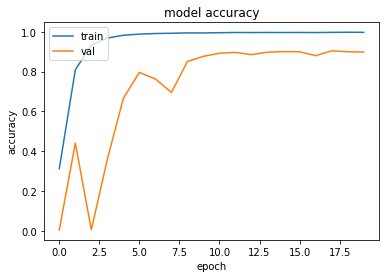

In [23]:
from matplotlib import pyplot as plt
plt.plot(his.history['categorical_accuracy'])
plt.plot(his.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

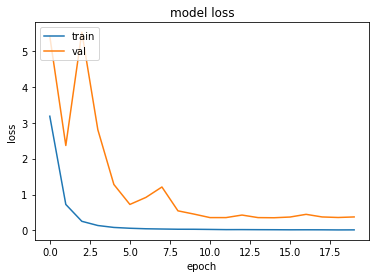

In [24]:
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()